This notebook is duplicated from "Thesis_fixed_time_data_full" with the only difference that we take only the top 5 importants features.

# Imports

In [1]:
import pandas as pd
import psycopg2

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap
from sklearn import metrics
from plot_classification_report import plot_classification_report

# Read Data Set

In [2]:
df = pd.read_csv("mergeData_fixed_time.csv")
df.head()

,pedId,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,...,gender,age,job,LatestDegree,oftenDrive,accidents,yearsDriving,lastDrive(years),speedingTickets,hadCollision
0,1.0,6.978462,0.493644,0.947244,0.813465,-0.000623,13.607109,0.000420,0.021339,0.032907,...,0,32,0,0,2,0,10,1.0,0,0
1,3.0,7.045599,0.504890,0.875541,0.911211,-0.045255,33.663919,0.000176,0.065360,0.002429,...,0,32,0,0,2,0,10,1.0,0,0
2,15.0,10.263041,0.478319,0.817679,0.595013,-0.017068,76.873997,0.001610,0.105119,0.076302,...,0,32,0,0,2,0,10,1.0,0,1
3,2.0,11.669419,0.500661,0.891913,0.522365,0.008028,47.209285,0.000396,0.055982,0.112551,...,0,32,0,0,2,0,10,1.0,0,0
4,4.0,12.187044,0.499769,0.861132,0.558120,0.001881,42.031423,0.000430,0.102442,0.079023,...,0,32,0,0,2,0,10,1.0,0,0


### Understanding features

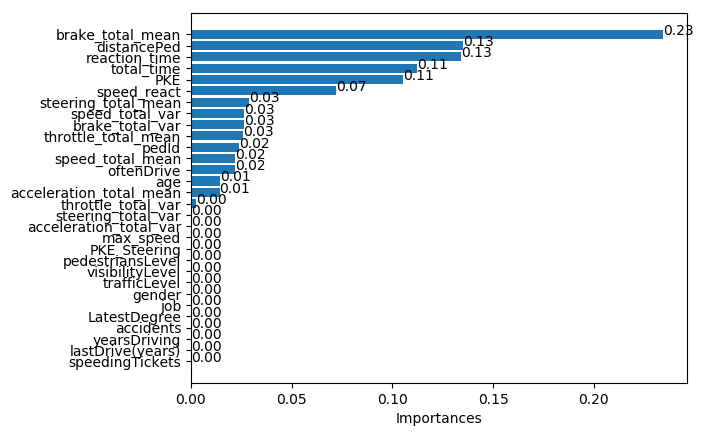

In [3]:
from sklearn.tree import DecisionTreeClassifier
data = df.copy()
X = data.drop('hadCollision', axis=1) 
Y = data['hadCollision']

classifier = DecisionTreeClassifier()
classifier.fit(X, Y)

importances_zip = zip(X.columns, classifier.feature_importances_)
importances_sorted = sorted(importances_zip, key=lambda tup: tup[1], reverse=True)
columns = []
importances = []
for name, importance in importances_sorted:
    columns.append(name)
    importances.append(importance)

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(columns, importances, align='center')
for index,value in enumerate(importances):
    ax.text(value, index, str("{:.2f}".format(value)))

ax.set_yticks(X.columns)
ax.set_yticklabels(X.columns)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importances')

plt.show()

In [4]:
data = data[['brake_total_mean','total_time', 'distancePed', 'reaction_time', 'PKE', 'hadCollision']]

In [5]:
data.head()

,brake_total_mean,total_time,distancePed,reaction_time,PKE,hadCollision
0,0.947244,9.958178,68.920520,1.048791,1.110623,0
1,0.875541,9.961018,69.359540,2.106615,0.084626,0
2,0.817679,9.941460,96.885284,0.079211,5.246326,1
3,0.891913,7.505478,88.011610,1.161592,2.969647,0
4,0.861132,8.681609,105.973686,1.275896,4.033468,0


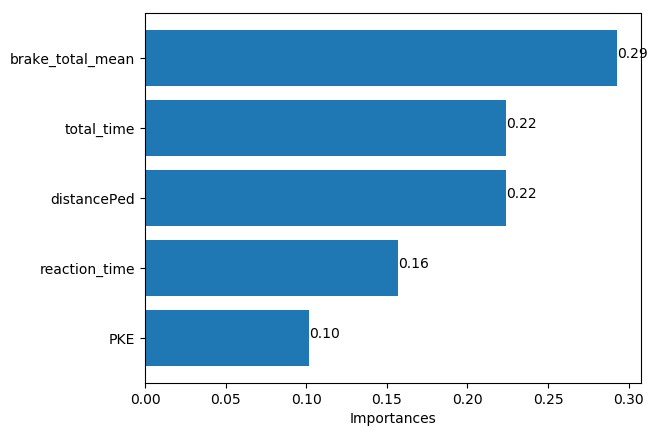

In [6]:
X = data.drop('hadCollision', axis=1) 
Y = data['hadCollision']

classifier = DecisionTreeClassifier()
classifier.fit(X, Y)

importances_zip = zip(X.columns, classifier.feature_importances_)
importances_sorted = sorted(importances_zip, key=lambda tup: tup[1], reverse=True)
columns = []
importances = []
for name, importance in importances_sorted:
    columns.append(name)
    importances.append(importance)

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(columns, importances, align='center')
for index,value in enumerate(importances):
    ax.text(value, index, str("{:.2f}".format(value)))

ax.set_yticks(X.columns)
ax.set_yticklabels(X.columns)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importances')

plt.show()

Importances has change now, having distancePed in first place.

### Context

The data source is created from "thesis_molding_fixed_time.ipynb" from the initial data set of GTA, Driving simulator and demographic data.

&nbsp; Each row cames from every pedestrian that driver cross. So we have many rows for every scenario (depending on how many pedestrians where in that scenario) and many scenarios from every driver (there are 5 scenarios). 
    
&nbsp; We took a previous fixed period of time of every pedestrian (taking a tail of rows from the initial data set of every pedestrian identified) and having as the target feature the result of the collision between the car and the pedestrian.

The columns in this merged data are:
- **brake_total_mean**: mean from brake pedal from Driving simulator in that period of time
- **total_time**: time in seconds of that period of time (can be different because some pedestrians appear quickly or some drivers where stopped on a traffic light).
- **distancePed**: initial distance between the driver and the pedestrian
- **PKE**: Agressive driving measure considering drastic movements of speed 
- **reaction_time**: time in seconds from when the pedestrian started running until there was a reaction in the driver's brake pedal
- **hadCollision**: False: 0, True: 1
    

### Distribution of cases

In [7]:
num_obs = len(df)
num_true = len(df.loc[df['hadCollision'] == 1])
num_false = len(df.loc[df['hadCollision'] == 0])
print("Number of True cases:  {0} ({1:2.2f}%)".format(num_true, (num_true/num_obs) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false, (num_false/num_obs) * 100))

Number of True cases:  37 (7.60%)
Number of False cases: 450 (92.40%)


We have considerably more false cases than true ones.

## Split data set

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=1, stratify=Y)

In [9]:
def print_split_data_set(X_train, X_test, y_train, y_test):
    print("Training True  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
    print("Training False : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
    print("")
    print("Test True      : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
    print("Test False     : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))
    
print_split_data_set(X_train, X_test, y_train, y_test)

Training True  : 22 (7.53%)
Training False : 270 (92.47%)

Test True      : 15 (7.69%)
Test False     : 180 (92.31%)


Normally I divide the data in 60% for training and 40% for test, having as target the column 'hadCollision'. I choose this percentages due to having a poor number of true cases. However I will try different combinations to see which has better results.

# Predictions

First I will start with the DecisionTree that made the feature importances plot.

### Auxiliar function for random repeats

In [10]:
def default_train_test_split(test_size):
    return train_test_split(X, Y, test_size=test_size, stratify=Y)

def repite_model_predict_algorithm( fit_function, predict_function, repetitions=50, test_size=0.4, split_fuction=default_train_test_split):
    y_pred_total = []
    y_test_total = []
    for i in range(repetitions):
        X_train, X_test, y_train, y_test = split_fuction(test_size)
        fit_function(X_train, y_train)
        y_pred = predict_function(X_test)
        y_pred_total.append(y_pred)
        y_test_total.append(y_test)
    
    y_test_total = [val for sublist in y_test_total for val in sublist]
    y_pred_total = [val for sublist in y_pred_total for val in sublist]
    lookup = {0: 'No Hit', 1:'Yes Hit'}
    y_true_pd = pd.Series([lookup[_] for _ in y_test_total])
    y_pred_pd = pd.Series([lookup[_] for _ in y_pred_total])
    
    summarize_results(y_true_pd, y_pred_pd)

    
def summarize_results(y_true_pd, y_pred_pd):
    print("Total Accuracy: %{0:.2f}".format(accuracy_score(y_true_pd, y_pred_pd)*100))
    print("")
    print("Confusion Matrix")
    print("")
    tab = pd.crosstab(y_true_pd, y_pred_pd, rownames=['True'], colnames=['Predicted'], margins=False)

    print(tab)
    print("")    
    plot_confusion_matrix(metrics.confusion_matrix(y_true_pd, y_pred_pd))

    #print("Classification Report")
    print("")
    cr = metrics.classification_report(y_true_pd, y_pred_pd)
    #print(cr)
    plot_classification_report(cr)

In [11]:
def plot_confusion_matrix(matrix):

    ax1 = pie_plot(1, 'No Hits predictions', matrix[0], ['g','r'], ['No Hit', 'Hit'])
    ax2 = pie_plot(2, 'Hits predictions recall', [matrix[1][1], matrix[1][0]], ['g','r'], ['Hit', 'No Hit'])

    plt.show()
    
def pie_plot(i, title, sizes, colors, labels):
    ax1 = plt.subplot(2,2,i)

    ax1.set_title(title)
    ax1.pie(sizes, explode=(0, 0.1), labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors)
    
    ax1.axis('equal')
    return ax1

## Decision Tree

Total Accuracy: %92.97

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     173380     6620
Yes Hit      7091     7909



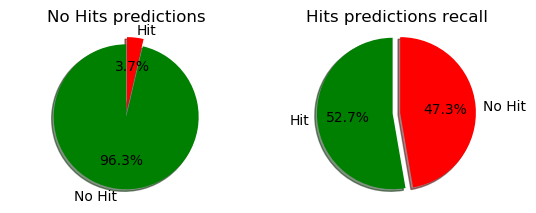

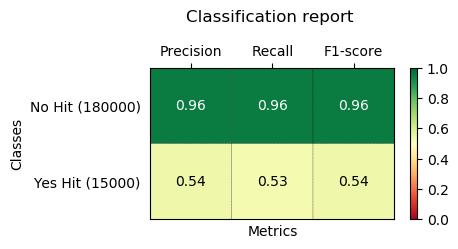

In [12]:
from sklearn.metrics import accuracy_score 
from sklearn import tree

clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.4)

We can see a slight improvement comparing with full data, having in every component more than 50% of assertions.

## KNN classifier

### Search for best n neighbors number

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X, Y)
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 4}

### KNN classifier with n=4

Total Accuracy: %93.82

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      90613      387
Yes Hit      5670     1330



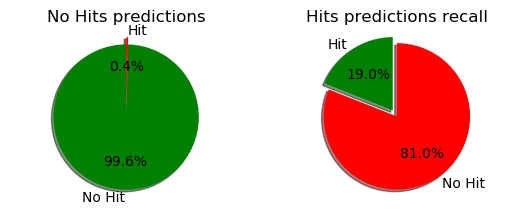

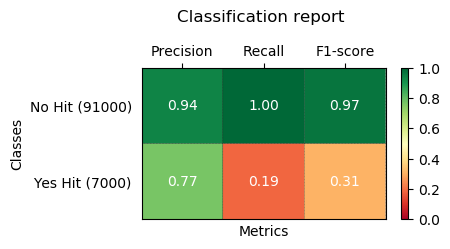

In [14]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.2)

This case is similar to full data

## Random Forest

Total Accuracy: %94.34

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     134178     1822
Yes Hit      6503     4497



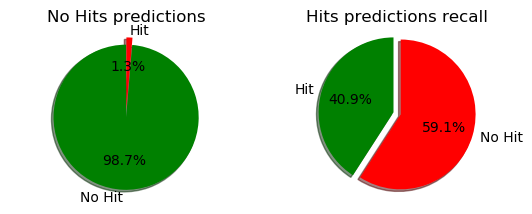

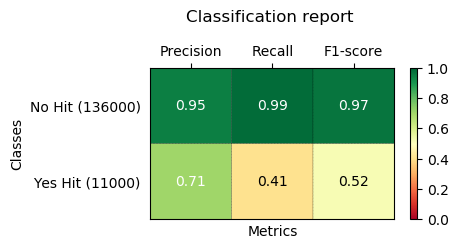

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)

We can see here again a slight improvement comparing with full data, having a good precision and a F1-score more than 50%.

# Over sampling data

Now we will try increasing the numbers of true cases with different over sampling approachs:

## Random Over Sampler

In [16]:
from imblearn.over_sampling import RandomOverSampler

def random_over_sampler_split(test_size):
    ros = RandomOverSampler()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

def print_over_sampling_fuction(split_function, test_size):
    X_resampled, X_test, y_resampled, y_test = split_function(test_size)
    print_split_data_set(X_resampled, X_test, y_resampled, y_test)

In [17]:
print_over_sampling_fuction(random_over_sampler_split, 0.4)

Training True  : 270 (50.00%)
Training False : 270 (50.00%)

Test True      : 15 (7.69%)
Test False     : 180 (92.31%)


Here we can see that False cases were splitted normally and "Training True" cases are now equals to falses.

### Decision Tree

This algorith was ignore because results were worst than before (without over sampling data)

### KNN classifier

Total Accuracy: %89.25

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      84988     6012
Yes Hit      4526     2474



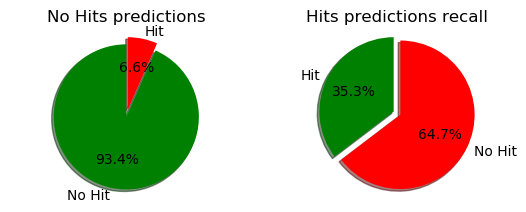

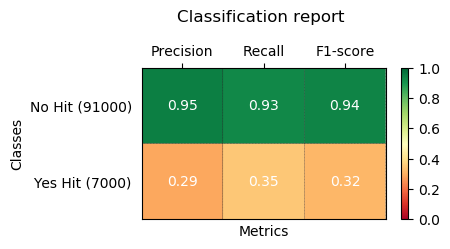

In [18]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.2, random_over_sampler_split)

This case is worst than with full data

### Random Forest

Total Accuracy: %93.61

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     176658     3342
Yes Hit      9125     5875



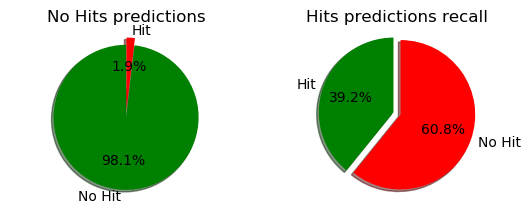

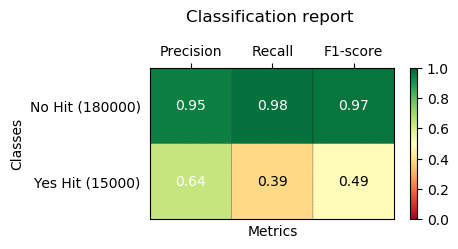

In [19]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.4, random_over_sampler_split)

We can see a little better recall for Hits predictions, always comparing full data.

## SMOTE

In [20]:
from imblearn.over_sampling import SMOTE, ADASYN

def smote_over_sampler_split(test_size):
    smote = SMOTE()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = smote.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

print_over_sampling_fuction(smote_over_sampler_split, 0.4)

Training True  : 270 (50.00%)
Training False : 270 (50.00%)

Test True      : 15 (7.69%)
Test False     : 180 (92.31%)


### Decision Tree

Total Accuracy: %86.84

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     161523    18477
Yes Hit      7183     7817



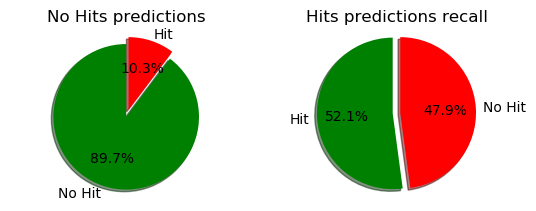

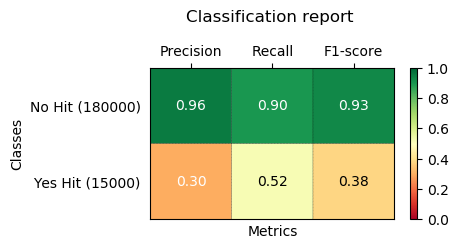

In [21]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.4, smote_over_sampler_split)

Slight improvement

### KNN classifier

Total Accuracy: %85.93

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      81078     9922
Yes Hit      3866     3134



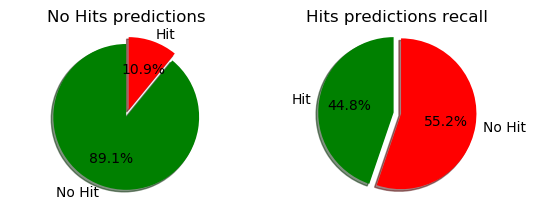

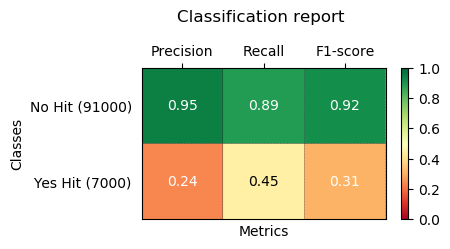

In [22]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.2, smote_over_sampler_split)

Similar to full data case.

### Random Forest

Total Accuracy: %89.92

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     125995    10005
Yes Hit      4806     6194



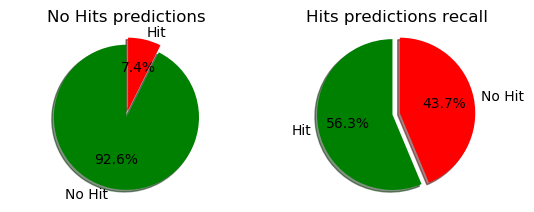

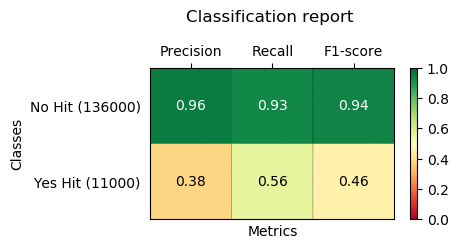

In [23]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3, smote_over_sampler_split)

Slight improvement

## ADASYN

In [24]:
def adasyn_over_sampler_split(test_size):
    adasyn = ADASYN()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = adasyn.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

print_over_sampling_fuction(adasyn_over_sampler_split, 0.4)

Training True  : 268 (49.81%)
Training False : 270 (50.19%)

Test True      : 15 (7.69%)
Test False     : 180 (92.31%)


This oversampling it's not totally exactly when doing the true training cases. So it's not exactly 50% of each.

### Decision Tree

Ignored

### KNN classifier

Total Accuracy: %78.86

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     145960    34040
Yes Hit      7188     7812



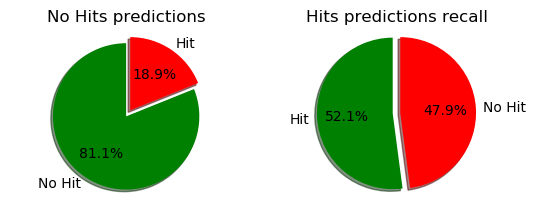

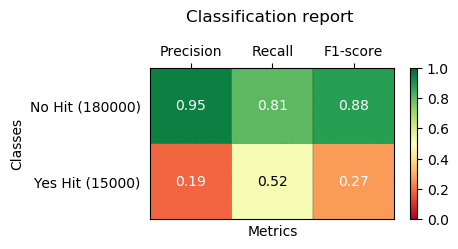

In [25]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.4, adasyn_over_sampler_split)

Similar recall to Smote but worst precision. Similar to full data case.

### Random Forest

Total Accuracy: %81.84

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     150912    29088
Yes Hit      6315     8685



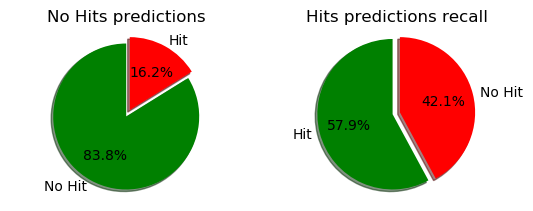

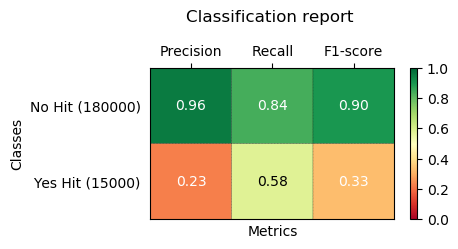

In [26]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.4, adasyn_over_sampler_split)

Better results from full data.

# Changing training data

I will try training the data with the same numbers of false cases and true cases but this time with less false cases:

In [27]:
def equal_cases_split(training_size_positives):
    return split_cases(training_size_positives, training_size_positives)

def double_false_cases_split(training_size_positives):
    return split_cases(training_size_positives, training_size_positives*2)

def split_cases(positive_training_size, negative_training_size):
    positives = data.loc[df['hadCollision'] == 1].copy()
    negatives = data.loc[df['hadCollision'] == 0].copy()
    test_size_pos = len(positives) - positive_training_size
    test_size_neg = len(negatives) - negative_training_size

    X_train_pos, X_test_pos = train_test_split(positives, train_size=positive_training_size, test_size=test_size_pos)
    X_train_neg, X_test_neg = train_test_split(negatives, train_size=negative_training_size, test_size=test_size_neg)
    X_train_total = X_train_pos.append(X_train_neg)
    X_test_total = X_test_pos.append(X_test_neg)

    X_train_total = X_train_total.sample(frac=1).reset_index(drop=True)
    X_test_total = X_test_total.sample(frac=1).reset_index(drop=True)
    X_train = X_train_total.drop('hadCollision', axis=1) 
    y_train = X_train_total['hadCollision']

    X_test = X_test_total.drop('hadCollision', axis=1) 
    y_test = X_test_total['hadCollision']
    return X_train, X_test, y_train, y_test

def print_results_with_size(split_function, train_size_pos):
    X_train, X_test, y_train, y_test = split_function(train_size_pos)
    print("Training True  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
    print("Training False : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
    print("")
    print("Test True      : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
    print("Test False     : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))

In [28]:
print_results_with_size(equal_cases_split, 30)

Training True  : 30 (50.00%)
Training False : 30 (50.00%)

Test True      : 7 (1.64%)
Test False     : 420 (98.36%)


We have now a training set of only 60 cases with 50% hits and 50% no hits. I decided to take 30 true cases as it's almost de 80% of true cases for training.

### Decision Tree

Total Accuracy: %75.64

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     317666   102334
Yes Hit      1692     5308



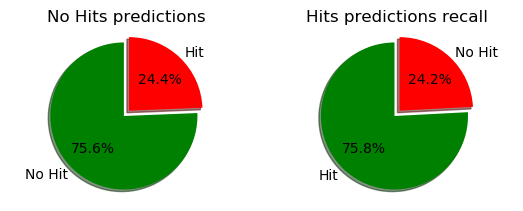

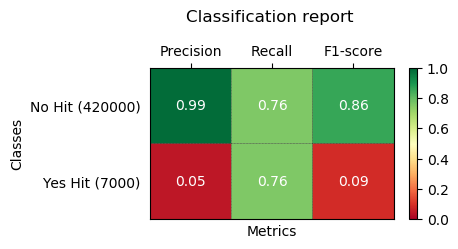

In [29]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 30, equal_cases_split)

Similar to full data.

In [30]:
print_results_with_size(double_false_cases_split, 20)

Training True  : 20 (33.33%)
Training False : 40 (66.67%)

Test True      : 17 (3.98%)
Test False     : 410 (96.02%)


Trying with the double of false cases for training in order to get more precision of "Yes Hit" cases, but this time taking only 20 true cases for training.

Total Accuracy: %83.54

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     345212    64788
Yes Hit      5497    11503



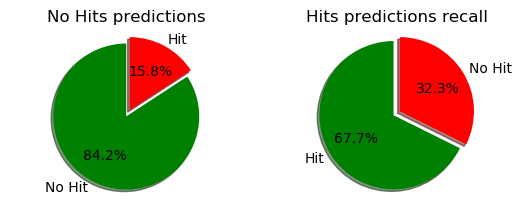

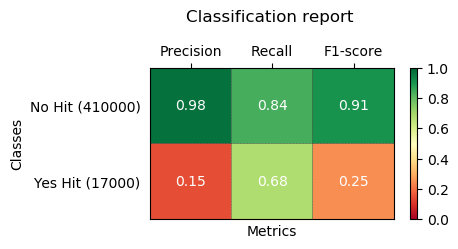

In [31]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 20, double_false_cases_split)

Similar full data.

### Knn

Total Accuracy: %86.50

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     366758    53242
Yes Hit      4421     2579



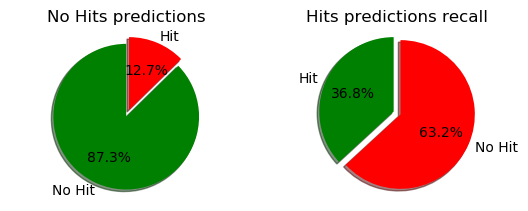

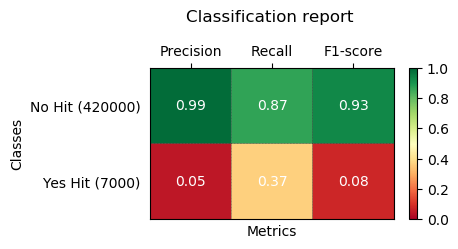

In [32]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000,  30, equal_cases_split)

Worst metrics as before

Total Accuracy: %95.12

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     375698    14302
Yes Hit      5071     1929



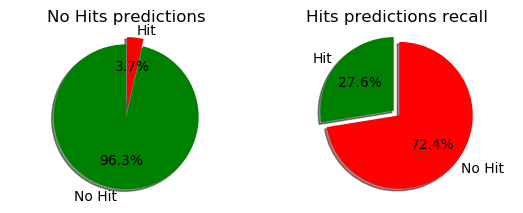

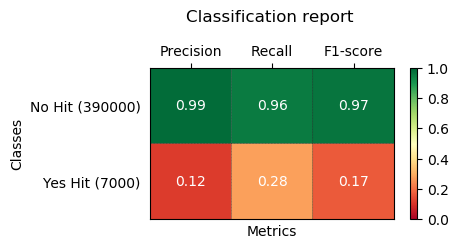

In [33]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000,  30, double_false_cases_split)

Worst metrics than with full data.

### Random Forest

Total Accuracy: %82.75

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     348130    71870
Yes Hit      1784     5216



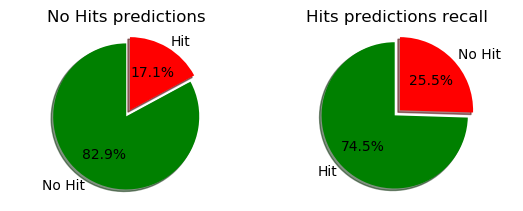

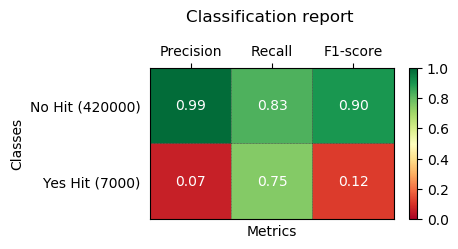

In [34]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 30, equal_cases_split)

We have same precision but a bit more recall from before.

Total Accuracy: %90.17

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     374423    35577
Yes Hit      6381    10619



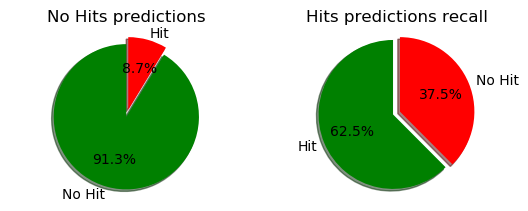

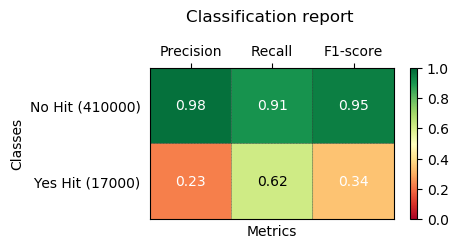

In [35]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 20, double_false_cases_split)

Little bit more recall than before.

# Weights classes

## Balanced

### Decision Tree

Total Accuracy: %91.87

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      87258     3742
Yes Hit      4223     2777



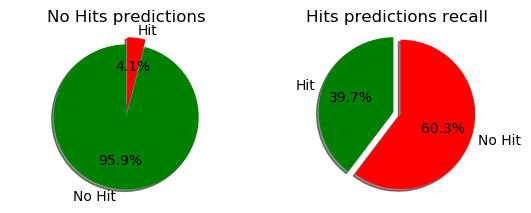

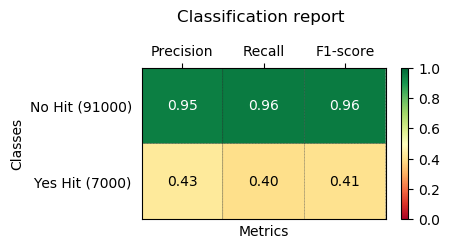

In [36]:
clf = tree.DecisionTreeClassifier(class_weight='balanced')

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.2)

Worst than default case.

### KNN

Default value is 'uniform' or balance, so I will try with distance

Total Accuracy: %93.25

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     178583     1417
Yes Hit     11755     3245



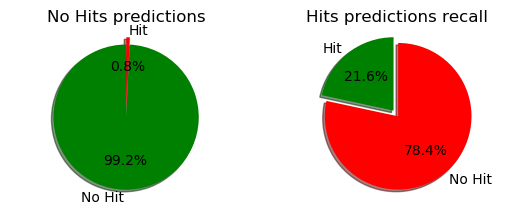

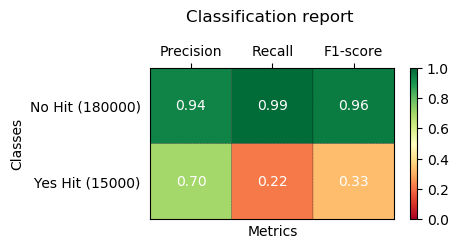

In [37]:
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')

repite_model_predict_algorithm(knn.fit, knn.predict, 1000,  0.4)

Same overfitting as default case

### Random Forest

#### Balanced

Total Accuracy: %94.08

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     135236      764
Yes Hit      7944     3056



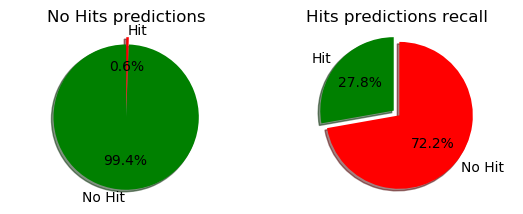

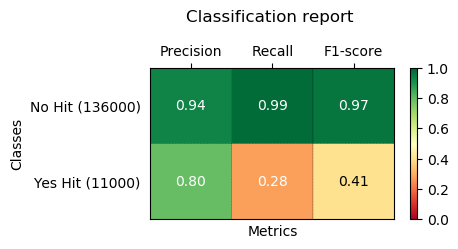

In [38]:
rf_model = RandomForestClassifier(class_weight="balanced")
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)

Same overfitting as default.

#### Balanced Subsample

Total Accuracy: %93.07

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     135557      443
Yes Hit      9745     1255



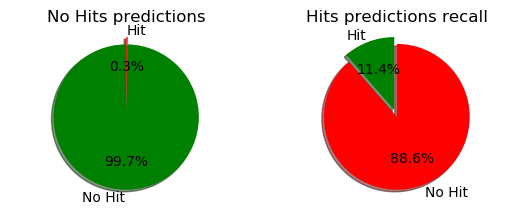

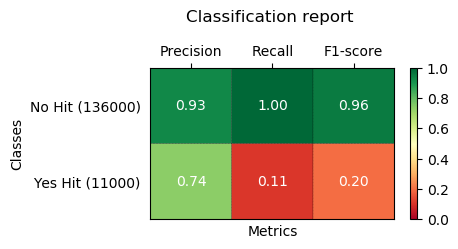

In [56]:
rf_model = RandomForestClassifier(class_weight="balanced_subsample")
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)

Same overfitting as default

### Decision Tree

In [39]:
from IPython.core.display import display, Markdown

def print_header(header):
    raw_html = "<h3>"+header+"</h3>"
    display( Markdown(raw_html) )

<h3>Running: Default model-prediction</h3>

Total Accuracy: %92.57

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     172546     7454
Yes Hit      7042     7958



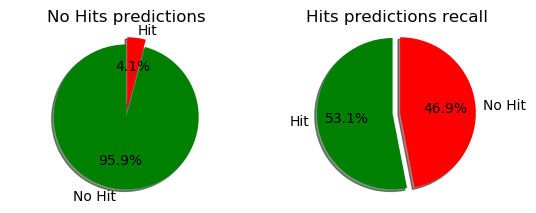

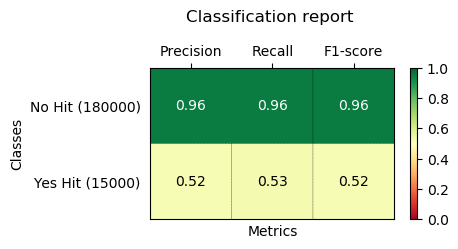

<h3>Running: Random Over Sampler</h3>

Total Accuracy: %93.53

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      87707     3293
Yes Hit      3043     3957



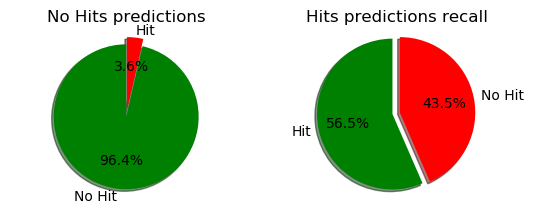

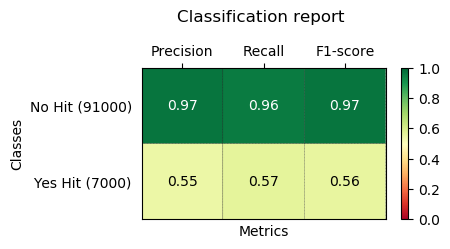

<h3>Running: SMOTE</h3>

Total Accuracy: %86.81

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     159392    20608
Yes Hit      5118     9882



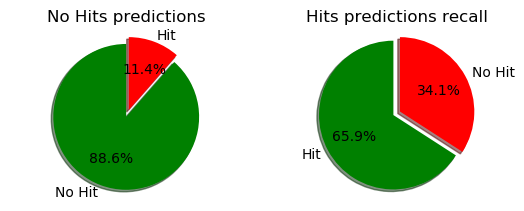

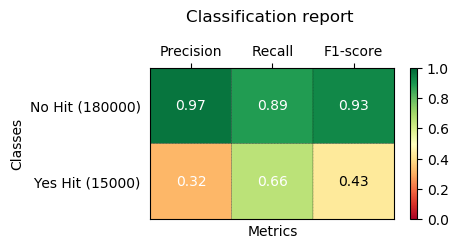

<h3>Running: ADASYN</h3>

Total Accuracy: %70.28

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     127821    52179
Yes Hit      5767     9233



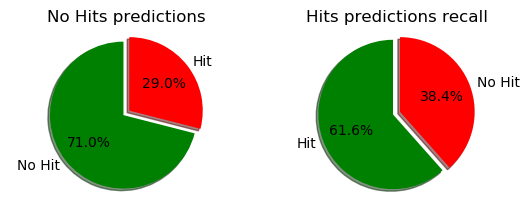

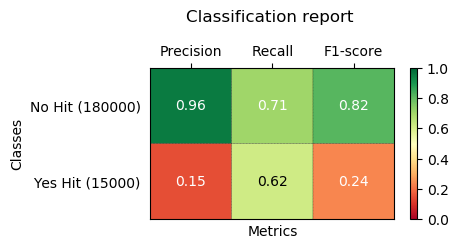

<h3>Running: Equal training cases</h3>

Total Accuracy: %76.05

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     319055   100945
Yes Hit      1331     5669



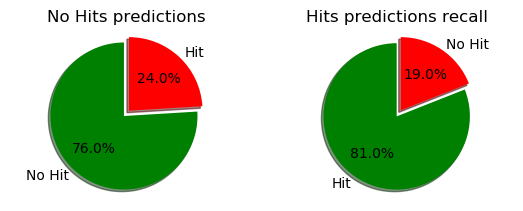

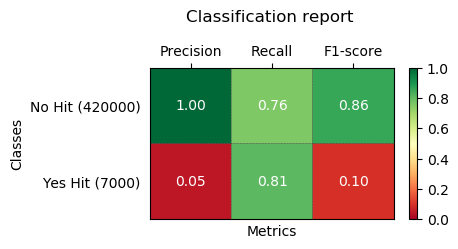

<h3>Running: Double false training cases</h3>

Total Accuracy: %84.66

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     330838    59162
Yes Hit      1719     5281



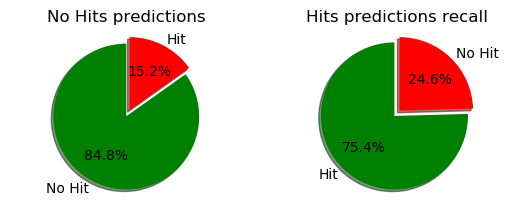

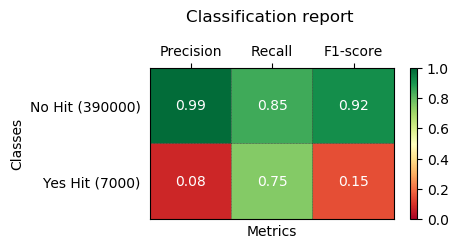

In [40]:
def run_all_models(clf):
    print_header("Running: Default model-prediction")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.4)

    print_header("Running: Random Over Sampler")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.2, random_over_sampler_split)

    print_header("Running: SMOTE")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.4, smote_over_sampler_split)

    print_header("Running: ADASYN")

    repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.4, adasyn_over_sampler_split)

    print_header("Running: Equal training cases")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 30, equal_cases_split)

    print_header("Running: Double false training cases")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 30, double_false_cases_split)
    
clf = tree.DecisionTreeClassifier(class_weight={0:10, 1:1})
run_all_models(clf)

Again we can see a slight improvement but similar cases as with full data. So we can say is better with less data in this case.

### Knn

I didn't find Knn class_weigths, it has a function weigth but I think is only weigths per feature:
    
    - [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.

### Random Forest

<h3>Running: Default model-prediction</h3>

Total Accuracy: %94.11

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     133380     2620
Yes Hit      6041     4959



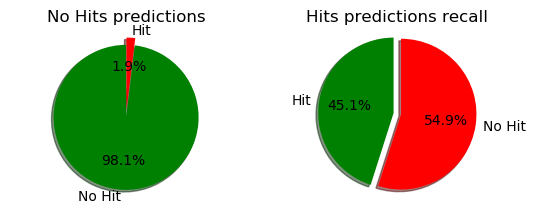

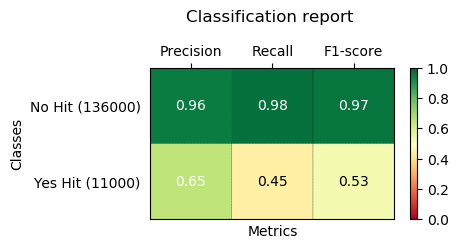

<h3>Running: Random Over Sampler</h3>

Total Accuracy: %93.89

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     175130     4870
Yes Hit      7039     7961



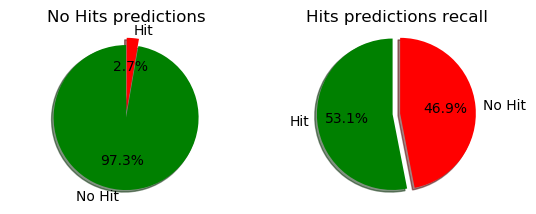

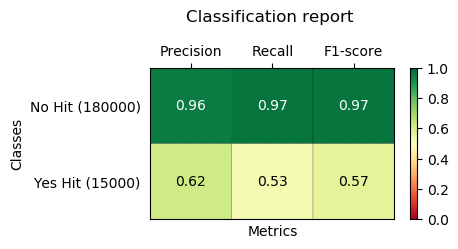

<h3>Running: SMOTE</h3>

Total Accuracy: %90.03

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     124569    11431
Yes Hit      3227     7773



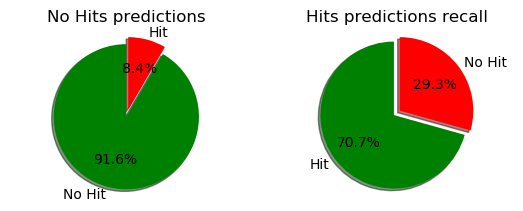

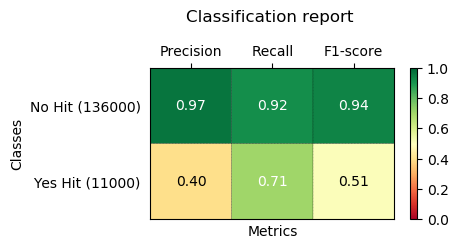

<h3>Running: ADASYN</h3>

Total Accuracy: %80.45

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     145390    34610
Yes Hit      3513    11487



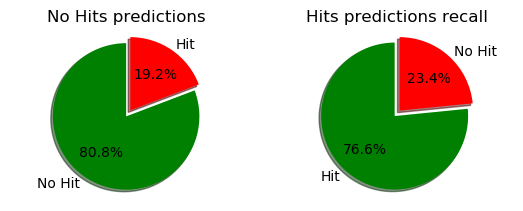

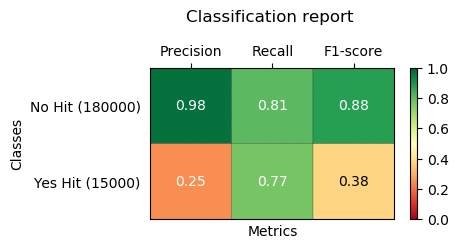

<h3>Running: Equal training cases</h3>

Total Accuracy: %83.52

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     350905    69095
Yes Hit      1290     5710



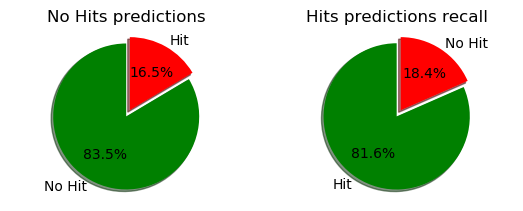

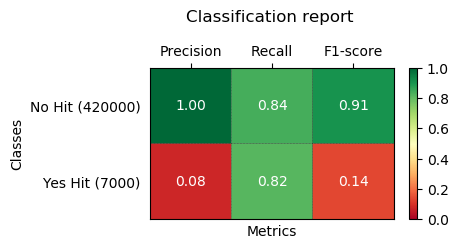

<h3>Running: Double false training cases</h3>

Total Accuracy: %90.56

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     354361    35639
Yes Hit      1848     5152



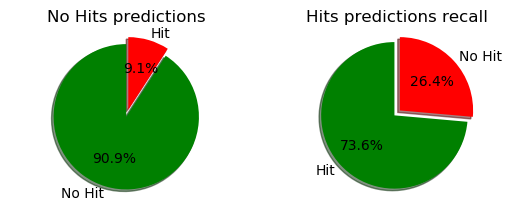

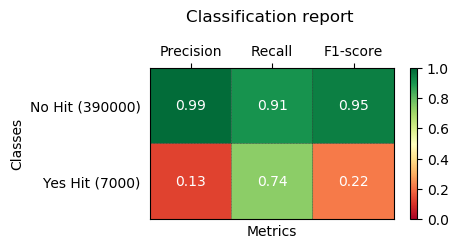

In [41]:
def run_all_models(rf_model):
    print_header("Running: Default model-prediction")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)
    
    print_header("Running: Random Over Sampler")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.4, random_over_sampler_split)

    print_header("Running: SMOTE")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3, smote_over_sampler_split)

    print_header("Running: ADASYN")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.4, adasyn_over_sampler_split)
    
    print_header("Running: Equal training cases")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 30, equal_cases_split)

    print_header("Running: Double false training cases")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 30, double_false_cases_split)
    
rf_model = RandomForestClassifier(class_weight={0:10, 1:1})
run_all_models(rf_model)

We can see acceptable results speacially with over samplers. Also with this case we can say is better than with full data.